In [1]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report, roc_auc_score, log_loss, precision_recall_fscore_support, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from itertools import cycle

# Lichess Move Classification using Pattern Complexity Formula with Multinomial Logistic Regression

In [2]:
# Load the data
df = pd.read_csv('/kaggle/input/chess-fen-cp-data/final_data.csv')

# Drop rows with NaN values in the specified columns
df = df.dropna(subset=[
    'constellation_cp_change', 'const_11_nodes_searched', 
    'cp_sd_diff', 
    'idf', 'reaction_move_type','white_elo','black_elo'
])

# Remove rows where 'const_11_cp' is not between -3000 and 3000 and 'constellation_cp_change' is not between -3000 and 3000
df = df[(df['const_11_cp'] >= -3000) & (df['const_11_cp'] <= 3000) & 
        (df['constellation_cp_change'] >= -3000) & (df['constellation_cp_change'] <= 3000)]

# Count the total number of rows (occurrences of constellations)
total_occurrences = len(df)
print(f'Total number of occurrences of constellations: {total_occurrences}')

# Count the number of unique 'game_id', 'constellation_str' and player ids
unique_game_id_count = df['game_id'].nunique()
unique_constellation_str_count = df['constellation_str'].nunique()
unique_player_ids = pd.concat([df['white_id'], df['black_id']]).nunique()

print(f'Number of unique game_id: {unique_game_id_count}')
print(f'Number of unique constellation_str: {unique_constellation_str_count}')
print(f'Number of unique player_id: {unique_player_ids}')

# Create Elo Rating variable
df['Elo_diff'] = df.apply(lambda row: row['black_elo'] - row['white_elo'] if row['player_made'] == 'White' else row['white_elo'] - row['black_elo'], axis=1)

df['Elo_player'] = df.apply(lambda row: row['black_elo'] if row['player_made'] == 'White' else row['white_elo'], axis=1)

# Elo ratings dont have incremental effects

# Define mapping for 'reaction_move_type'
custom_mapping = {'Blunder': 1, 'Mistake': 2, 'Inaccuracy': 3, 'Optimal': 4}
df['reaction_move_type_encoded'] = df['reaction_move_type'].map(custom_mapping)

# Get unique patterns and their counts
pattern_counts = df['constellation_str'].value_counts()

# Convert pattern_counts to a DataFrame and reset the index
pattern_counts_df = pattern_counts.reset_index()
pattern_counts_df.columns = ['constellation_str', 'count']

# Shuffle the DataFrame with a fixed random seed
shuffled_patterns = pattern_counts_df.sample(frac=1, random_state=137)

# Calculate the number of patterns for the 80% split
total_patterns = len(df)
train_size = int(total_patterns * 0.8)

# Initialize the train and test dataframes
train_df = pd.DataFrame(columns=df.columns)
test_df = pd.DataFrame(columns=df.columns)

# Iterate over the shuffled patterns and distribute them to train and test sets
for _, row in shuffled_patterns.iterrows():
    pattern = row['constellation_str']
    count = row['count']
    pattern_df = df[df['constellation_str'] == pattern]
    
    if len(train_df) + count <= train_size:
        train_df = pd.concat([train_df, pattern_df])
    else:
        test_df = pd.concat([test_df, pattern_df])

print(f"Length of train_df: {len(train_df)}")
print(f"Length of test_df: {len(test_df)}")

# Reapply the custom mapping to the 'reaction_move_type' column in train_df and test_df
train_df['reaction_move_type_encoded'] = train_df['reaction_move_type'].map(custom_mapping)
test_df['reaction_move_type_encoded'] = test_df['reaction_move_type'].map(custom_mapping)

# Define the independent variables and dependent variable for the train and test sets
X_train = train_df[['constellation_cp_change', 'const_11_nodes_searched', 'cp_sd_diff', 'idf']]
y_train = train_df['reaction_move_type_encoded']

X_test = test_df[['constellation_cp_change', 'const_11_nodes_searched', 'cp_sd_diff', 'idf']]
y_test = test_df['reaction_move_type_encoded']

# Filter X_train and X_test based on the valid indices in y_train and y_test
X_train = X_train.loc[y_train.index]
X_test = X_test.loc[y_test.index]

# Normalize the independent variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the model on the training data with balanced class weights
model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs', class_weight='balanced')
model.fit(X_train_scaled, y_train)

# Function to calculate standard errors
def calculate_se(X, y, model):
    p = model.predict_proba(X)
    n_classes = len(model.classes_)
    n_features = X.shape[1]
    se = np.zeros((n_classes, n_features))
    for k in range(n_classes):
        X_weighted = X * np.sqrt(p[:, k] * (1 - p[:, k]))[:, np.newaxis]
        se[k] = np.sqrt(np.linalg.pinv(X_weighted.T.dot(X_weighted)).diagonal())
    return se

# Calculate standard errors
se = calculate_se(X_train_scaled, y_train, model)

# Create a table with b, se, z-score, p-value, odds ratio, and CI for each coefficient and intercept
table_data = []
feature_names = ['Intercept'] + list(X_train.columns)
for class_label, class_value in custom_mapping.items():
    index = class_value - 1
    coef = np.insert(model.coef_[index], 0, model.intercept_[index])
    se_class = np.insert(se[index], 0, np.sqrt(np.diag(np.linalg.inv(X_train_scaled.T.dot(X_train_scaled))))[0])
    z_scores = coef / se_class
    p_values = 2 * (1 - stats.norm.cdf(np.abs(z_scores)))
    odds_ratios = np.exp(coef)
    ci_lower = np.exp(coef - 1.96 * se_class)
    ci_upper = np.exp(coef + 1.96 * se_class)
    
    for i, feature in enumerate(feature_names):
        table_data.append({
            'Class': class_label,
            'Feature': feature,
            'b': coef[i],
            'SE': se_class[i],
            'z-score': z_scores[i],
            'p-value': p_values[i],
            'Odds Ratio': odds_ratios[i],
            'CI Lower': ci_lower[i],
            'CI Upper': ci_upper[i]
        })

# Create and display the table
table_df = pd.DataFrame(table_data)
print(table_df.to_string(index=False))

# Predict on the testing data
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, zero_division=0, target_names=['Blunder', 'Mistake', 'Inaccuracy', 'Optimal'])
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
logloss = log_loss(y_test, y_pred_proba)

# Calculate weighted precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

# Print metrics
print("\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"\nConfusion Matrix:\n{conf_matrix}")
print(f"\nClassification Report:\n{class_report}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Log Loss: {logloss:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-score: {f1:.4f}")


Total number of occurrences of constellations: 106810
Number of unique game_id: 31688
Number of unique constellation_str: 2277
Number of unique player_id: 19215


/tmp/ipykernel_18/1569227912.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_df = pd.concat([train_df, pattern_df])
/tmp/ipykernel_18/1569227912.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_df = pd.concat([test_df, pattern_df])


Length of train_df: 85448
Length of test_df: 21362
     Class                 Feature         b       SE     z-score      p-value  Odds Ratio  CI Lower  CI Upper
   Blunder               Intercept -2.099575 0.003528 -595.120912 0.000000e+00    0.122508  0.121664  0.123359
   Blunder constellation_cp_change  1.490145 0.013445  110.832762 0.000000e+00    4.437740  4.322323  4.556239
   Blunder const_11_nodes_searched  0.076970 0.020937    3.676268 2.366705e-04    1.080010  1.036587  1.125251
   Blunder              cp_sd_diff  2.164329 0.021233  101.930187 0.000000e+00    8.708757  8.353758  9.078842
   Blunder                     idf  0.361903 0.019495   18.563407 0.000000e+00    1.436059  1.382221  1.491994
   Mistake               Intercept  0.086216 0.003528   24.437685 0.000000e+00    1.090041  1.082530  1.097605
   Mistake constellation_cp_change  0.386494 0.010525   36.720242 0.000000e+00    1.471812  1.441760  1.502490
   Mistake const_11_nodes_searched -0.129625 0.012468  -10.39

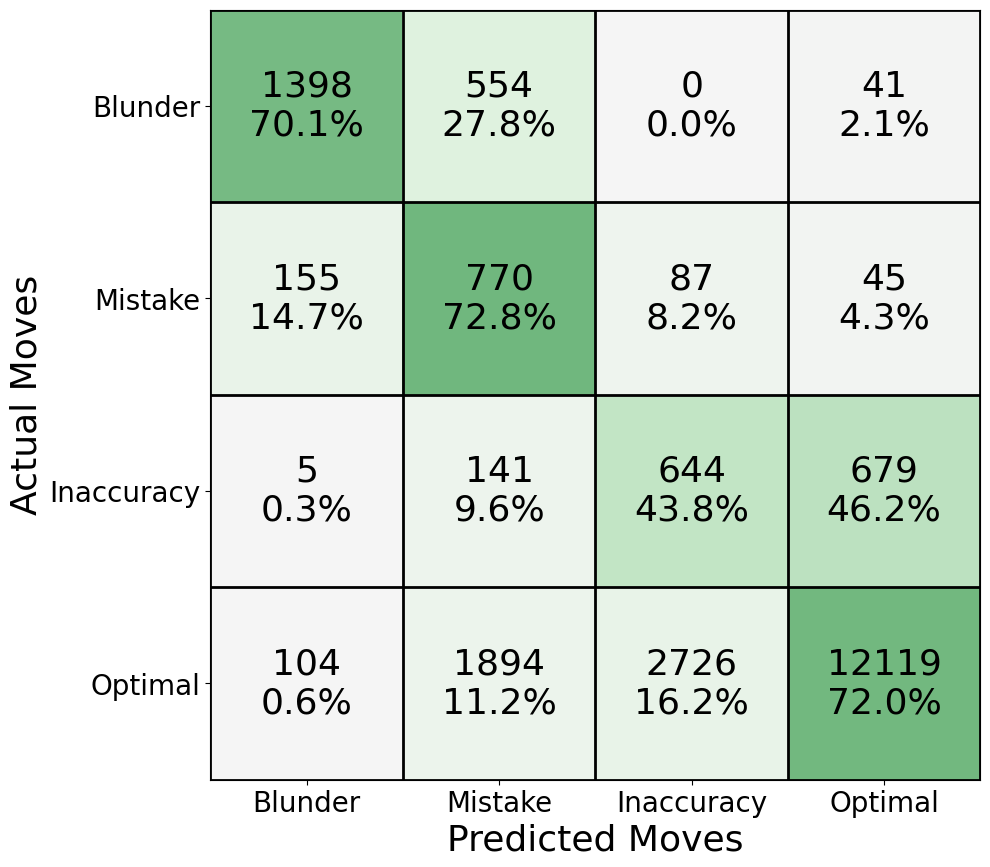

In [3]:
# Compute the confusion matrix with normalization by true classes
conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')

# Compute the confusion matrix without normalization to get exact numbers
conf_matrix_counts = confusion_matrix(y_test, y_pred)

# Convert normalized confusion matrix to percentages
conf_matrix_percentage = conf_matrix * 100


# Create a custom colormap
colors = ["#f5f5f5", "#d9f2d9", "#70b77e"]
n_bins = [3, 6, 10, 100]  # Discretizes the interpolation into bins
cmap_name = 'custom_green'

# Create the colormap
cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

# Create the ConfusionMatrixDisplay without plotting
cmd = ConfusionMatrixDisplay(conf_matrix_percentage, display_labels=[f'{key}' for key in custom_mapping.keys()])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(20, 10))
cmd.plot(cmap=cm, ax=ax, values_format='', colorbar=False)

# Remove the text annotations created by ConfusionMatrixDisplay
for text in ax.texts:
    text.set_visible(False)

# Add custom text annotations for percentages and counts
for i in range(conf_matrix_percentage.shape[0]):
    for j in range(conf_matrix_percentage.shape[1]):
        percentage_text = f'{conf_matrix_percentage[i, j]:.1f}%'
        count_text = f'{conf_matrix_counts[i, j]}'
        color = 'white' if conf_matrix_percentage[i, j] > 80 else 'black'
        ax.text(j, i, f'{count_text}\n{percentage_text}', ha='center', va='center', color=color, fontsize=26)

# Add borders (grid lines)
ax.set_xticks([x - 0.5 for x in range(1 + len(custom_mapping))], minor=True)
ax.set_yticks([y - 0.5 for y in range(1 + len(custom_mapping))], minor=True)
ax.grid(which="minor", color="black", linestyle='-', linewidth=2)
ax.tick_params(which="minor", size=0)

plt.xlabel('Predicted Moves', fontsize=26)
plt.ylabel('Actual Moves', fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.show()

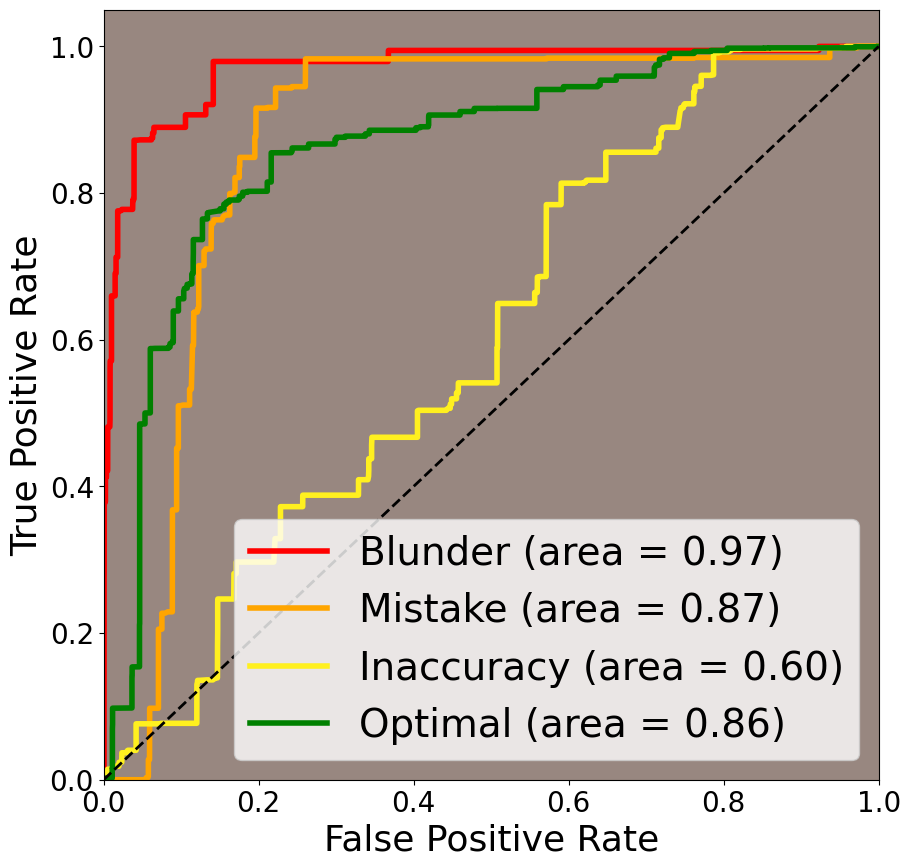

In [4]:
# Binarize the output
y_test_binarized = label_binarize(y_test, classes=[1, 2, 3, 4])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
fig, ax = plt.figure(figsize=(10, 10)), plt.gca()

# Set background color for the plot area
ax.set_facecolor('#988780')

colors = cycle(['Red', 'Orange', '#FFF01F', 'Green'])
for i, (class_label, color) in enumerate(zip(custom_mapping.keys(), colors)):
    plt.plot(fpr[i], tpr[i], color=color, lw=4,
             label=f'{class_label} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=26)
plt.ylabel('True Positive Rate', fontsize=26)
plt.legend(loc="lower right", fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [5]:
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier

# Function to calculate bootstrap F1 scores
def bootstrap_f1(model, X_test, y_test, n_iterations=1000, random_state=137):
    np.random.seed(random_state)
    scores = []
    for _ in range(n_iterations):
        X_resample, y_resample = resample(X_test, y_test)
        y_pred_resample = model.predict(X_resample)
        score = f1_score(y_resample, y_pred_resample, average='weighted')
        scores.append(score)
    return scores

# Function to perform permutation test
def permutation_test(model_scores, nir_scores, n_permutations=1000, random_state=137):
    np.random.seed(random_state)
    observed_diff = np.mean(model_scores) - np.mean(nir_scores)
    combined_scores = np.array(model_scores + nir_scores)
    count = 0
    for _ in range(n_permutations):
        np.random.shuffle(combined_scores)
        new_model_scores = combined_scores[:len(model_scores)]
        new_nir_scores = combined_scores[len(model_scores):]
        new_diff = np.mean(new_model_scores) - np.mean(new_nir_scores)
        if new_diff >= observed_diff:
            count += 1
    p_value = count / n_permutations
    return p_value

# Create and fit an NIR model (most frequent class)
nir_model = DummyClassifier(strategy='most_frequent')
nir_model.fit(X_train_scaled, y_train)

# Bootstrap F1 scores for main model
model_f1_scores = bootstrap_f1(model, X_test_scaled, y_test)

# Bootstrap F1 scores for the NIR model
nir_f1_scores = bootstrap_f1(nir_model, X_test_scaled, y_test)

# Calculate 95% confidence intervals
model_f1_ci = np.percentile(model_f1_scores, [2.5, 97.5])
nir_f1_ci = np.percentile(nir_f1_scores, [2.5, 97.5])

print(f"Model F1 Score 95% CI: {model_f1_ci}")
print(f"NIR Model F1 Score 95% CI: {nir_f1_ci}")

# Compare means and confidence intervals
model_f1_mean = np.mean(model_f1_scores)
nir_f1_mean = np.mean(nir_f1_scores)

print(f"Mean Model F1 Score: {model_f1_mean:.4f}")
print(f"Mean NIR Model F1 Score: {nir_f1_mean:.4f}")

# Perform permutation test
p_value = permutation_test(model_f1_scores, nir_f1_scores)
print(f"P-value from permutation test: {p_value:.4f}")

Model F1 Score 95% CI: [0.74414385 0.75503735]
NIR Model F1 Score 95% CI: [0.68754642 0.70280119]
Mean Model F1 Score: 0.7495
Mean NIR Model F1 Score: 0.6951
P-value from permutation test: 0.0000


In [6]:
# Calculating VIF
X = df[['constellation_cp_change', 'const_11_nodes_searched', 'cp_sd_diff', 'idf']]
X_with_constant = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_constant.values, i+1) for i in range(len(X.columns))]

print(vif_data)

                   feature       VIF
0  constellation_cp_change  1.062022
1  const_11_nodes_searched  1.093870
2               cp_sd_diff  1.039891
3                      idf  1.010107
